# Environment setup

In [20]:
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from shapely.geometry import Point

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key('9e1a5f8a49df4346986d94f82fb13fcc')

# Data access

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Region of Interest

In [59]:
# Define latitude and longitude coordinates
LAT_IS = 45.812246
LON_IS = -90.092743

# Create a point geometry for the location of interest
point = Point(LON_IS, LAT_IS)

time_of_interest = "2016-06-01/2017-06-30"

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=point,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)
# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")



APIError: 16 validation errors for Request
body -> intersects -> type
  unexpected value; permitted: 'Point' (type=value_error.const; given=Polygon; permitted=['Point'])
body -> intersects -> coordinates
  wrong tuple length 1, expected 2 (type=value_error.tuple.length; actual_length=1; expected_length=2)
body -> intersects -> coordinates
  wrong tuple length 1, expected 3 (type=value_error.tuple.length; actual_length=1; expected_length=3)
body -> intersects -> type
  unexpected value; permitted: 'MultiPoint' (type=value_error.const; given=Polygon; permitted=['MultiPoint'])
body -> intersects -> coordinates -> 0 -> 0
  value is not a valid float (type=type_error.float)
body -> intersects -> coordinates -> 0 -> 1
  value is not a valid float (type=type_error.float)
body -> intersects -> coordinates -> 0
  wrong tuple length 2, expected 3 (type=value_error.tuple.length; actual_length=2; expected_length=3)
body -> intersects -> type
  unexpected value; permitted: 'LineString' (type=value_error.const; given=Polygon; permitted=['LineString'])
body -> intersects -> coordinates
  ensure this value has at least 2 items (type=value_error.list.min_items; limit_value=2)
body -> intersects -> type
  unexpected value; permitted: 'MultiLineString' (type=value_error.const; given=Polygon; permitted=['MultiLineString'])
body -> intersects -> coordinates -> 0
  ensure this value has at least 4 items (type=value_error.list.min_items; limit_value=4)
body -> intersects -> type
  unexpected value; permitted: 'MultiPolygon' (type=value_error.const; given=Polygon; permitted=['MultiPolygon'])
body -> intersects -> coordinates -> 0 -> 0
  ensure this value has at least 4 items (type=value_error.list.min_items; limit_value=4)
body -> intersects -> coordinates -> 0 -> 1
  ensure this value has at least 4 items (type=value_error.list.min_items; limit_value=4)
body -> intersects -> type
  unexpected value; permitted: 'GeometryCollection' (type=value_error.const; given=Polygon; permitted=['GeometryCollection'])
body -> intersects -> geometries
  field required (type=value_error.missing)

In [41]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

asset_href = least_cloudy_item.assets["visual"].href

Choosing S2A_MSIL2A_20160731T170312_R069_T15TYL_20210212T095128 from 2016-07-31 with 0.033067% cloud cover


In [57]:
import rasterio
from rasterio.windows import Window
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

# Define the coordinates of the point (LAT_IS, LON_IS)
point_lon, point_lat = -90.092743, 45.812246

# Define the size of the window around the point (in meters or degrees)
window_size = 100  # adjust this value as needed

with rasterio.open(asset_href) as ds:
    # Get the bounds of the area of interest
    aoi_bounds = (point_lon - 0.5, point_lat - 0.5, point_lon + 0.5, point_lat + 0.5)
    
    # Transform the bounds to the same CRS as the raster dataset
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    
    # Calculate the row and column indices corresponding to the point
    row, col = ds.index(point_lon, point_lat)
    
    # Define the window around the point
    window = Window(col - window_size // 2, row - window_size // 2, window_size, window_size)
    
    # Read the data within the window
    band_data = ds.read(window=window)
    
    # Print information about the extracted data
    print("Bounds of the AOI:", warped_aoi_bounds)
    print("Shape of the band data:", band_data.shape)
    
    # Create an image from the band data
    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    img.show()

# Resize the image
target_w, target_h = 800, 600  # adjust target width and height as needed
img_resized = img.resize((target_w, target_h), Image.BILINEAR)
img_resized.show()

Bounds of the AOI: (685345.7606162996, 5020456.935012857, 767079.8467765765, 5134384.899914715)
Shape of the band data: (3, 0, 0)


ValueError: tile cannot extend outside image

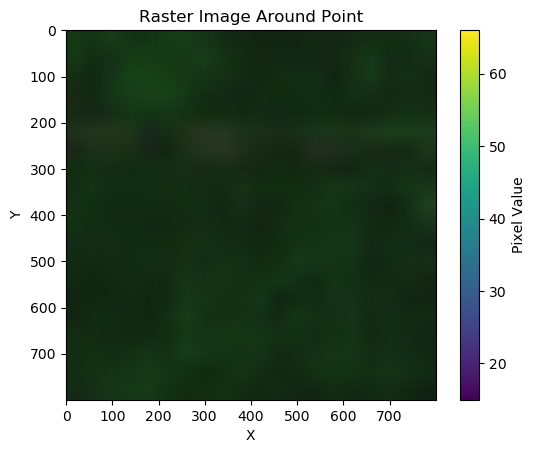

In [47]:
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(img_resized)
plt.title('Raster Image Around Point')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Pixel Value')
plt.show()
